# Stock Market Clustering 

# Abstract: 
In this project, we study market behavior through unsupervised learning by applying Principal Component Analysis (PCA) and K-means clustering to daily stock return data. PCA is first used to reduce dimensionality and capture dominant market factors, resulting in a set of ten principal components. K-means clustering is then applied to the reduced data to group dates with similar return patterns, effectively identifying distinct market regimes. The resulting clusters are analyzed through a timeline visualization, mean return profiles, and a heatmap of cluster centroids. Our results show that market regimes are primarily driven by the first few principal components, with higher-order components contributing minimally. The identified clusters correspond to stable, volatile, and transitional market conditions, providing an interpretable framework for understanding temporal market dynamics. 


# Step1: Load the Data 

In [165]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Load data
SP500_DATA_CSV = 'sp500_data.csv.gz'
sp500_px = pd.read_csv('sp500_data.csv.gz', index_col = 0, parse_dates = True)
# Filter columns (stocks) with almost all zeros
active_stocks = sp500_px.loc[:, (df != 0).any(axis=0)]
print(active_stocks.head()) 

# Slice recent data 
recent_start = '2011-01-01'
df = active_stocks.loc[active_stocks.index >= recent_start] 
print(df.head()) 

# Confirm the data quality 
print(df.isna().sum().sum(), "total NaNs in price data")
print(df.isna().any(axis=1).sum(), "rows containing at least one NaN")

            ADS        CA      MSFT  RHT  CTSH       CSC       EMC       IBM  \
1993-01-29  0.0  0.060124 -0.022100  0.0   0.0  0.018897  0.007368  0.092165   
1993-02-01  0.0 -0.180389  0.027621  0.0   0.0  0.018889  0.018425  0.115207   
1993-02-02  0.0 -0.120257  0.035900  0.0   0.0 -0.075573  0.029482 -0.023041   
1993-02-03  0.0  0.060124 -0.024857  0.0   0.0 -0.151128  0.003689 -0.253454   
1993-02-04  0.0 -0.360770 -0.060757  0.0   0.0  0.113350 -0.022114  0.069862   

                 XRX      ALTR  ...  WAT  ALXN     AMGN  BXLT     BIIB  \
1993-01-29  0.259140 -0.007105  ...  0.0   0.0  0.34716   0.0  0.04167   
1993-02-01 -0.100775  0.063893  ...  0.0   0.0 -0.23144   0.0  0.00000   
1993-02-02  0.028796 -0.014192  ...  0.0   0.0 -0.11572   0.0  0.00000   
1993-02-03 -0.043190 -0.007105  ...  0.0   0.0 -0.08679   0.0  0.04167   
1993-02-04  0.000000 -0.007096  ...  0.0   0.0  0.14465   0.0 -0.04166   

               CELG      GILD  REGN    VRTX  HSIC  
1993-01-29  0.00000  0

# The data is already standardized and represents returns.

# PART A: PCA on stock prices (no transpose)

In [168]:
pca = PCA(n_components = 10)
X_pca = pca.fit_transform(df) 
print(X_pca.shape) 

(1131, 10)


In [169]:
# Top contributing stocks for each component
top_n = 10
components = pd.DataFrame(
    pca.components_,
    columns = df.columns,
    index = [f'PC{i+1}' for i in range(pca.n_components_)]
)
for pc in components.index:
    print(f"\nTop {top_n} stocks for {pc}:")
    print(components.loc[pc].abs().sort_values(ascending = False).head(top_n))




Top 10 stocks for PC1:
PCLN     0.625364
VXX      0.359264
CMG      0.208486
ISRG     0.202745
GOOGL    0.181971
AMZN     0.152154
REGN     0.136092
BLK      0.110863
BIIB     0.109315
AZO      0.105498
Name: PC1, dtype: float64

Top 10 stocks for PC2:
VXX      0.746315
PCLN     0.576243
ISRG     0.150884
GOOG     0.087469
REGN     0.087084
GOOGL    0.060651
BIIB     0.053680
JOY      0.042045
AMZN     0.039911
BLK      0.036884
Name: PC2, dtype: float64

Top 10 stocks for PC3:
PCLN    0.472564
VXX     0.453813
ISRG    0.341847
REGN    0.255478
CMG     0.228220
BIIB    0.204175
AZO     0.181301
ALXN    0.109318
BLK     0.108312
AGN     0.107487
Name: PC3, dtype: float64

Top 10 stocks for PC4:
ISRG     0.889889
PCLN     0.141574
BLK      0.121381
REGN     0.116077
AZO      0.110378
GOOGL    0.092303
GOOG     0.088363
AMZN     0.075375
PXD      0.069381
BIIB     0.069363
Name: PC4, dtype: float64

Top 10 stocks for PC5:
CMG      0.864850
REGN     0.314824
BIIB     0.236732
GOOGL    0.1

PC1 + PC2: 0.4898473820760192


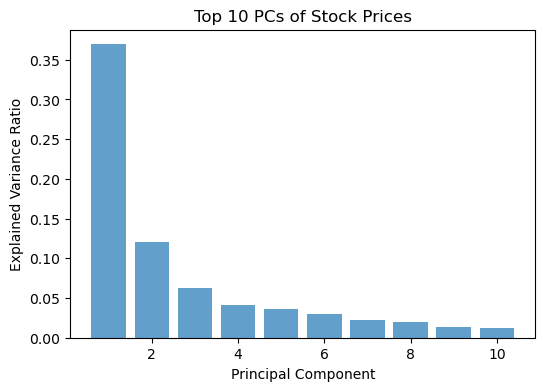

In [192]:
# Plot explained variance
print(f"PC1 + PC2: {pca.explained_variance_ratio_[:2].sum()}")
plt.figure(figsize = (6,4))
plt.bar(range(1,11), pca.explained_variance_ratio_, alpha = 0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Top 10 PCs of Stock Prices')
plt.show()


# Step 3 — Choose Number of Clusters (Elbow Method)

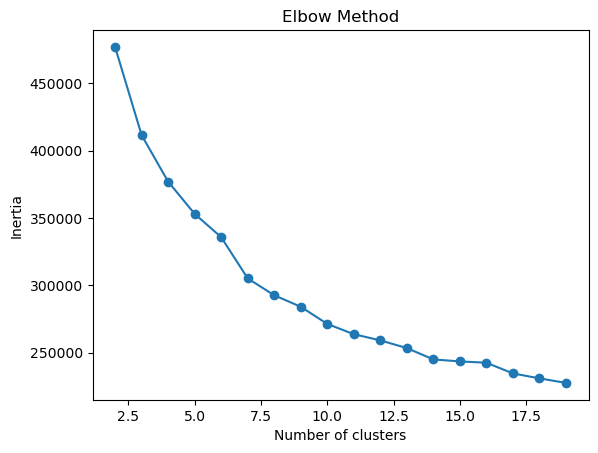

In [173]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(2, 20)

for k in k_range:
    km = KMeans(n_clusters = k, n_init = 'auto', random_state = 44)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Step 4 — Run K-means

In [180]:
kmeans = KMeans(n_clusters = 7, n_init = 'auto', random_state = 42).fit(X_pca)
# labels = kmeans.fit_predict(X)
# X_scaled['cluster'] = kmeans.labels_
# centers = pd.DataFrame(kmeans.cluster_centers_, index = sp500_px.index, columns = ['XOM', 'CVX']) 

clusters = pd.Series(kmeans.labels_, index = df.index, name = "cluster")
print(clusters.sort_values())


2012-01-18    0
2011-08-15    0
2011-08-11    0
2012-03-07    0
2011-08-09    0
             ..
2012-03-02    6
2012-03-06    6
2014-01-23    6
2013-10-30    6
2012-01-10    6
Name: cluster, Length: 1131, dtype: int32


In [181]:
from collections import Counter 
print(Counter(kmeans.labels_))

Counter({2: 401, 1: 236, 6: 224, 5: 82, 3: 80, 0: 78, 4: 30})


# Step 5 — Visualize (2D with PCA)

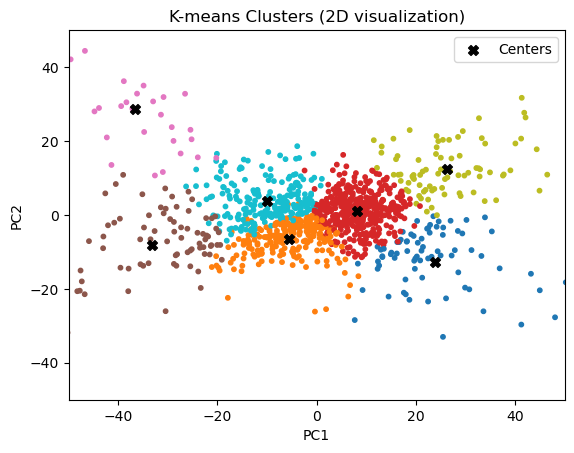

In [196]:
plt.scatter(X_pca[:,0], X_pca[:,1], c = kmeans.labels_, cmap = 'tab10', s = 10)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim([-50, 50])
plt.ylim([-50, 50])
plt.title("K-means Clusters (2D visualization)")

centers = kmeans.cluster_centers_

plt.scatter(
    centers[:,0], centers[:,1],
    c = 'black', s = 50, marker='X', label = 'Centers'
)
plt.legend()
plt.show() 

# 2. Timeline of Clusters (VERY IMPORTANT for financial data)


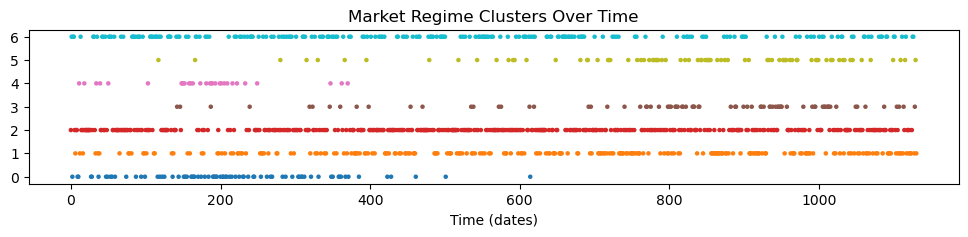

In [197]:
plt.figure(figsize=(12,2))
plt.scatter(range(len(kmeans.labels_)), kmeans.labels_, c = kmeans.labels_, cmap = 'tab10', s = 5)
plt.yticks(range(7))
plt.xlabel("Time (dates)")
plt.title("Market Regime Clusters Over Time")
plt.show()

Each date is colored by its cluster → how market behavior changes over time.

The timeline of clusters reveals the evolution of market regimes over time. No single cluster dominates the entire period, indicating that the market does not remain in a fixed state but transitions between multiple behavioral patterns. 
* Cluster 2 appears consistently across the timeline and represents the baseline or typical market condition.
* In contrast, clusters such as 4 and 5 occur intermittently, suggesting temporary market phases or regime shifts.
* Overall, the market exhibits moderate persistence with regular transitions between regimes.

# 3. Cluster Mean Return Profile (Interpret clusters)

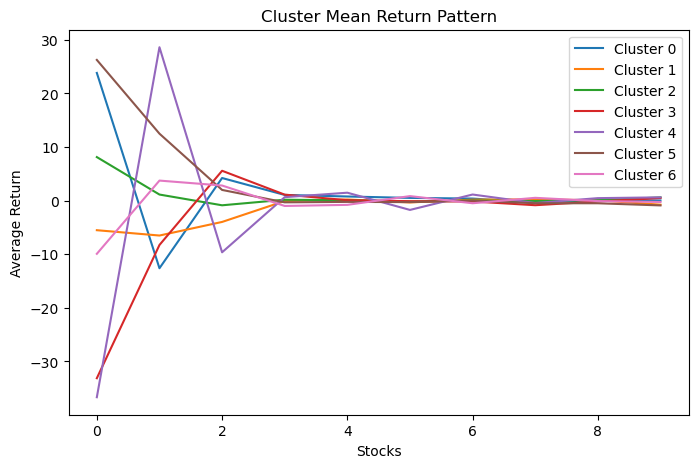

In [198]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(8,5))
for i in range(7):
    plt.plot(centers[i], label = f'Cluster {i}')
plt.legend()
plt.title("Cluster Mean Return Pattern")
plt.xlabel("Stocks")
plt.ylabel("Average Return")
plt.show()

The cluster mean return profiles reveal distinct market regimes primarily driven by the first few principal components. Significant variation occurs in the first two to three components, while higher-order components remain close to zero across all clusters, indicating limited influence. 
* Cluster 2 represents a stable baseline regime with mild positive exposure, whereas Clusters 3 and 4 capture extreme and highly volatile behaviors.
* Cluster 5 Cluster 5 corresponds to a strong positive market regime driven primarily by the first principal component.
* Clusters 0 and 6 exhibit opposing movements among dominant components, suggesting rotational or transitional market dynamics.
* Overall, the profiles confirm that the identified clusters correspond to meaningfully different market behaviors.

# 4. Heatmap of Cluster Centers (Best visual explanation)

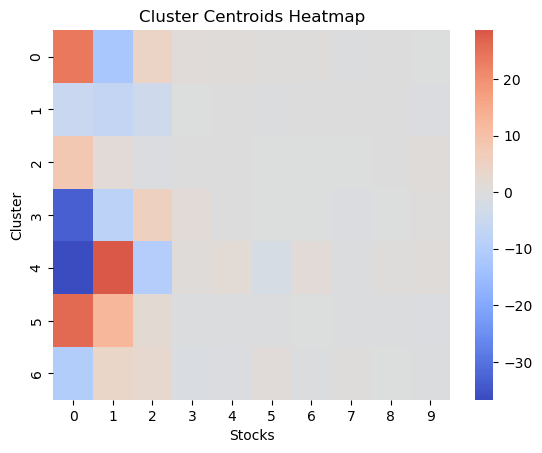

In [199]:
import seaborn as sns

sns.heatmap(centers, cmap = 'coolwarm', center=0)
plt.title("Cluster Centroids Heatmap")
plt.xlabel("Stocks")
plt.ylabel("Cluster")
plt.show()

- PC0–PC2 show strong structure
- PC3–PC9 are almost zero
* Cluster 5: strong positive PC0 and PC1 → bullish regime
* Cluster 3 & 4: strong negative PC0 → stress or shock regimes
* Cluster 0 & 6: mixed signs → transitional or rotational regimes
* Cluster 2: near-zero across components → baseline regime

The heatmap of cluster centroids provides a compact visualization of the differences between identified market regimes. Strong variations are concentrated in the first few principal components, while higher-order components remain close to zero across all clusters, confirming that regime separation is driven by dominant market factors. Distinct clusters exhibit markedly different sign and magnitude patterns, corresponding to bullish, bearish, and transitional market behaviors. This visualization supports the interpretation obtained from the mean return profiles and reinforces the effectiveness of PCA in reducing dimensionality prior to clustering.

# Step 6 — Conclusion 


This study demonstrates that combining PCA with K-means clustering provides an effective and interpretable approach to identifying market regimes from high-dimensional return data. The timeline of clusters reveals that market behavior evolves over time with no single regime dominating the entire period, while the mean return profiles characterize the distinct structure of each regime. The heatmap of cluster centroids confirms that regime separation is driven primarily by the leading principal components, validating the dimensionality reduction step. Overall, this mini project highlights how unsupervised learning techniques can be used to uncover meaningful patterns in financial time series while maintaining interpretability.